# Karhunen-Loève expansion

One may decompose certain stochastic processes into a bi-orthogonal series of uncorrelated and variance-ordered random variables. Such a **Karhunen-Loève expansion** (KLE) provides insights and lends itself to dimension reduction and simulation. Its discrete variant is demonstrated in the cells below. It is analogous to a **population PCA**. Note this representation is not specific to Gaussian processes in particular. It relates square-integrable stochastic processes in general.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist

from utils.kernels import SquaredExponential

In [3]:
torch.set_default_dtype(torch.float64)  # use double precision
_ = torch.manual_seed(7777)  # set random seed manually

## Covariance matrix

In [4]:
lower = -10
upper = 10
num_coords = 101

coords = torch.linspace(lower, upper, num_coords)

In [5]:
sigma = 1.0  # standard deviation
length = 1.0  # lengthscale parameter

kernel_rbf = SquaredExponential(sigma=sigma, length=length)

cov_rbf = kernel_rbf(coords, coords)

## Eigenvalues/vectors

In [6]:
eigenvalues, eigenvectors = torch.linalg.eigh(cov_rbf)  # ascending order

descending_ids = torch.argsort(eigenvalues, descending=True)  # descending order
eigenvalues = eigenvalues[descending_ids]
eigenvectors = eigenvectors[:,descending_ids]

explained_var = torch.cumsum(eigenvalues, dim=0) / torch.sum(eigenvalues)

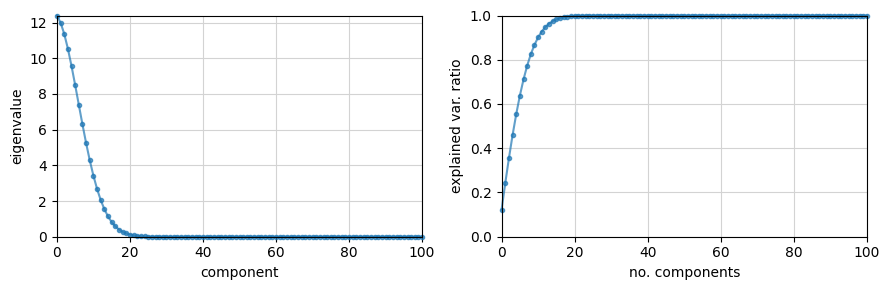

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

axes[0].plot(eigenvalues.numpy(), marker='.', alpha=0.7, clip_on=False)
axes[0].set(xlabel='component', ylabel='eigenvalue')
axes[0].set_xlim((0, len(eigenvalues)-1))
axes[0].set_ylim((0, eigenvalues.max()))

axes[1].plot(explained_var.numpy(), marker='.', alpha=0.7, clip_on=False)
axes[1].set(xlabel='no. components', ylabel='explained var. ratio')
axes[1].set_xlim((0, len(explained_var)-1))
axes[1].set_ylim((0, 1))

for ax in axes.ravel():
    ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
    ax.set_axisbelow(True)

fig.tight_layout()

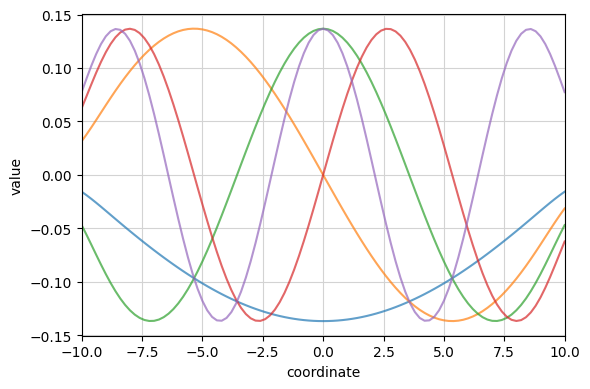

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(coords.numpy(), eigenvectors[:,:5].numpy(), alpha=0.7)
ax.set(xlabel='coordinate', ylabel='value')
ax.set_xlim((coords[0], coords[-1]))
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()

## Simulation

In [9]:
num_components = 25

retained_eigenvalues = eigenvalues[:num_components]
retained_eigenvectors = eigenvectors[:,:num_components]

In [10]:
num_samples = 10

normal_samples = dist.Normal(
    loc=torch.zeros_like(retained_eigenvalues),
    scale=torch.sqrt(retained_eigenvalues)
).sample((num_samples,))

samples = normal_samples @ retained_eigenvectors.T

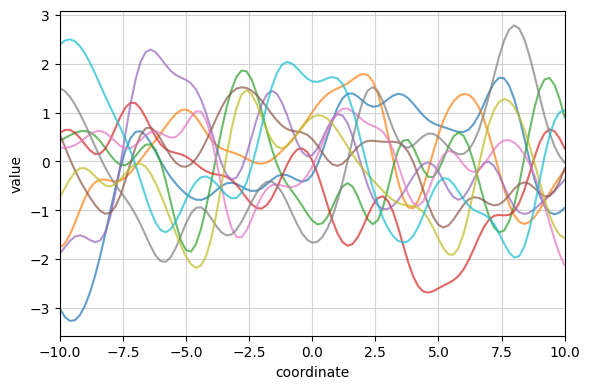

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(coords.numpy(), samples.T.numpy(), alpha=0.7)
ax.set(xlabel='coordinate', ylabel='value')
ax.set_xlim((coords[0], coords[-1]))
ax.grid(visible=True, which='both', color='lightgray', linestyle='-')
ax.set_axisbelow(True)
fig.tight_layout()